In [120]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm

In [9]:
voltage = 240
battery_volume = 60 * 1000 / voltage #amp
resistance = 0
power_boundary = 9.6* 1000
power_boundary_decrease_point= 0.8

In [11]:
action_size = 2
actions = [i for i in range(action_size)]
actions_prob = 1/action_size
charge_interval = 30
state_size_delta_soc = 101
state_size_delta_time = int((24*60/charge_interval))
state_size_time = int((24*60/charge_interval) *2)

In [12]:
current_list = np.linspace(0,40,action_size)
print(current_list)

[ 0. 40.]


In [13]:
price_max_value = 1

In [14]:
x = np.linspace(0, int(state_size_time)-1, int(state_size_time))
price_curve = price_max_value/((state_size_time/2)**2) * (x-(state_size_time/2))**2

In [ ]:
action_space = [i for i in range(action_size)]

In [ ]:
def step(state, action):
    new_state = [0, 0, 0]
    delta_soc = np.round(current_list[action] * charge_interval / battery_volume / 60, 1)
    new_state[0] = state[0] - delta_soc
    new_state[1] = state[1] - 1
    new_state[2] = state[2] + 1

    #     new_state[0] = np.round(state[0]*(1+increase_rate_tumor/100),1)
    #     new_state[1] = np.round(state[1]*(1+increase_rate_bad_feeling/100),1)
    #     new_state[0] = min(10, new_state[0])
    #     new_state[1] = min(10, new_state[1])
    #     new_state[0] = max(1, new_state[0])
    #     new_state[1] = max(1, new_state[1])
    #     new_state[2] = max(drugB_usage, state[2])
    if new_state[1] < 0:
        raise Exception("delta time out of bound")
    if new_state[2] >= state_size_time:
        raise Exception("current time out of bound")


    reward = -delta_soc * price_curve[state[2]]
    done = False
    if ((new_state[0] <= 0) or (new_state[1] <= 0) or (new_state[2] >= state_size_time)):
        if new_state[0] <= 0:
            reward += 1000
        done = True
    return new_state, reward, done

In [ ]:
def get_index(state):
    index = int(state/0.1)
    return index

In [ ]:
def compute_state_value(max_iter=9, discount=1.0, policy=actions_prob * np.ones(
    (state_size_delta_soc, state_size_delta_time, state_size_time, action_size))):
    new_state_values = np.zeros((state_size_delta_soc, state_size_delta_time, state_size_time))
    iteration = 0

    # while iteration <= max_iter:
    for _ in tqdm(range(max_iter)):
        state_values = new_state_values.copy()
        old_state_values = state_values.copy()

        for i in np.linspace(0, 1, state_size_delta_soc):
            for j in range(1, int(state_size_delta_time)):
                for m in range(int(state_size_time)-1):
                    i = np.round(i, 1)
                    j = np.round(j, 1)
                    index_i = get_index(i)
                    value = 0
                    for k, a in enumerate(actions):
                        (next_i, next_j, next_m), reward, done = step([i, j, m], a)
                        next_index_i = get_index(next_i)
                        value += policy[index_i, j, m, k] * (
                                    reward + discount * state_values[next_index_i, next_j, next_m])
                    new_state_values[index_i, j, m] = value

        iteration += 1

    return new_state_values, iteration

In [ ]:
# values, sync_iteration = compute_state_value(max_iter=1)

In [ ]:
def greedy_Policy(values,discount = 1):
    new_state_values = values
    policy = np.zeros((state_size_delta_soc, state_size_delta_time, state_size_time, action_size))
#     policy = np.zeros((grid_size,grid_size,4))

    state_values = new_state_values.copy()
    
    for i in np.linspace(0, 1, state_size_delta_soc):
        print(i)
        for j in range(1, int(state_size_delta_time)):
            for m in range(int(state_size_time)-1):
                value = np.min(values)
                for k,a in enumerate(actions):
                    i = np.round(i, 1)
                    index_i = get_index(i)
                    (next_i, next_j, next_m), reward, done = step([i, j, m], a)
                    next_index_i = get_index(next_i)
                    valtemp = reward + discount * state_values[next_index_i, next_j,next_m]
                    if valtemp > value:
                        actionind = k
                policy[index_i,j,m,actionind] = 1
                    
#     for i in range(grid_size):
#         for j in range(grid_size):
#             value = np.min(values);
#             for k,a in enumerate(actions):
#                 (next_i, next_j), reward = step([i, j], a)
#                 valtemp = reward + discount * state_values[next_i, next_j]
#                 if valtemp > value:
#                   value = valtemp
#                   actionind = k

#             policy[i,j,actionind] = 1

    return policy

In [ ]:
policy0 = actions_prob * np.ones((state_size_delta_soc, state_size_delta_time, state_size_time, action_size))
values, sync_iteration = compute_state_value(max_iter=5, policy = policy0)
greedy_policy = greedy_Policy(values)

values, sync_iteration = compute_state_value(max_iter=5, policy = greedy_policy)
greedy_policy = greedy_Policy(values)
values, sync_iteration = compute_state_value(max_iter=5, policy = greedy_policy)
greedy_policy = greedy_Policy(values)

plt.matshow(greedy_policy[:, :, 95, 1])
plt.show()

In [185]:
greedy_policy = np.load('greedy_policy_iter10.npy')

In [186]:
def check_policy(delta_soc, delta_t, current_t):
    I = np.zeros(96)

    for t in range(delta_t):
        action = greedy_policy[delta_soc, delta_t, current_t, 1]
        I[current_t] = greedy_policy[delta_soc, delta_t, current_t, 1]
        if action == 1:
            # charging
            delta_soc -= 1
        else:
            pass
        delta_t -= 1
        current_t += 1
    
    return I

In [198]:
I_delta_soc = []
delta_t = 47
current_t = 0
assert current_t + delta_t <= 96

for delta_soc in np.arange(0, 11):
    assert delta_soc <= delta_t
    I = check_policy(delta_soc, delta_t, current_t)
    I_delta_soc.append(I)
    print(f'socCharged for delta_soc = {delta_soc} is {sum(I)}')


socCharged for delta_soc = 0 is 0.0
socCharged for delta_soc = 1 is 1.0
socCharged for delta_soc = 2 is 2.0
socCharged for delta_soc = 3 is 3.0
socCharged for delta_soc = 4 is 4.0
socCharged for delta_soc = 5 is 5.0
socCharged for delta_soc = 6 is 6.0
socCharged for delta_soc = 7 is 7.0
socCharged for delta_soc = 8 is 8.0
socCharged for delta_soc = 9 is 9.0
socCharged for delta_soc = 10 is 10.0


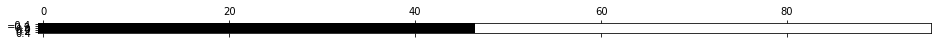

In [199]:
time_window = np.zeros(96)
t = current_t

for _ in range(delta_t):
    if t <= current_t + delta_t:
        time_window[t] = 1
        t += 1

plt.matshow(np.array(time_window)[np.newaxis, :], cmap=mpl.cm.Greys)
plt.show()

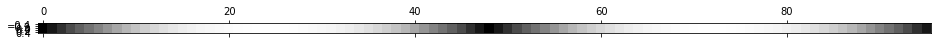

In [196]:
price_max_value = 1
x = np.linspace(0, int(state_size_delta_time)-1, int(state_size_delta_time))
price_curve = price_max_value/((state_size_delta_time/2)**2) * (x-(state_size_delta_time/2))**2
price_curve = np.concatenate((price_curve,price_curve),axis =0)

plt.matshow(price_curve[np.newaxis, :], cmap=mpl.cm.Greys)
plt.show()

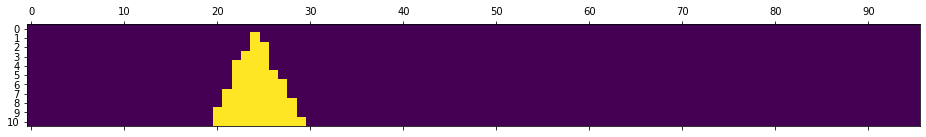

In [200]:
plt.matshow(np.array(I_delta_soc))
plt.xticks(np.arange(0, 96, 10))
plt.yticks(np.arange(0, 11, 1))
plt.show()

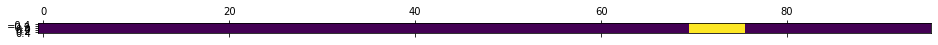

6.0


In [189]:
I = check_policy(6, delta_t, current_t)
plt.matshow(np.array(I)[np.newaxis, :])
plt.show()
print(sum(I))

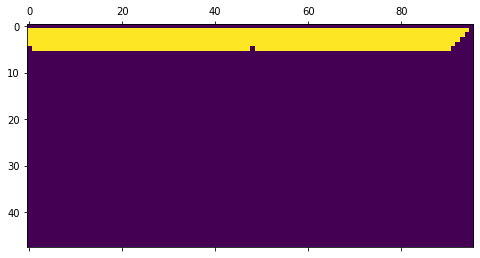

In [22]:
plt.matshow(greedy_policy[10, 24, :, 1])
plt.show()